# Advanced DL and RL: Домашнее задание 2.
<br>

![](logo.png)

Продвинутое машинное обучение: ДЗ 2<br>
Задание: [link](https://docs.google.com/document/d/1laNIbABgIdjLiwHbd0sl0l_A4qGZcuQaOlQNrza82bQ/)<br>
Выполнил: **Полянских Сергей**, 08.11.2021

1. [Часть первая: крестики-нолики при помощи Q-обучения](#Часть-первая:-крестики-нолики-при-помощи-Q-обучения)
  1. [Поле 3x3x3](#Поле-3x3x3)
  2. [Поле 4x4x4](#Поле-4x4x4)
  3. [Поле 5x5x3](#Поле-5x5x3)
2. [Часть вторая: добавим нейронных сетей](#Часть-вторая:-добавим-нейронных-сетей)
  1. [DQN](#DQN)
  2. [Double DQN](#Double-DQN)
3. [Часть третья: расширим и углубим поиск](#Часть-третья:-расширим-и-углубим-поиск)
  1. [Rollouts](#Rollouts)
  2. [MCTS](#MCTS)
4. [Вместо бонуса](#Planning)
8. [Выводы](#Выводы)

In [1]:
import random
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from utils import *

## Часть первая: крестики-нолики при помощи Q-обучения

Пишут, что Q обучение больше подходит для обучения одного игрока, а не нескольких. Т.е. на остальных игроков в Q обучении предполагается смотреть как на часть среды. При этом возможно сделать их игру, например, рандомной, либо взять игру противника из полного дерева (для 4 на 4 это еще возможно), либо попеременно обучать игроков.

Мне все-таки интересно было реализовать двух одновременно обучающихся агентов со своими Q таблицами. Это немного сложнее, но кажется более естественным и интересным.

In [2]:
class QAgent(BaseAgent):
    def __init__(self, env, player, alpha=0.1, gamma=1.0, eps=0.1, train=True, random=False):
        BaseAgent.__init__(self, env, player, gamma, eps, train)
        self.alpha = alpha
        self.random = random
        self.Q = defaultdict(lambda: np.zeros(env.n_rows*env.n_cols))

    def get_action(self, s):
        Qs = self.Q[s]
        
        while True:
            if self.random or (self.is_train and (random.random() < self.eps)):
                a = random.choice(self.env.getEmptySpaces())
            else:
                max_actions = np.where(Qs == Qs.max())[0]
                a = int(np.random.choice(max_actions))
                a = self.env.action_from_int(a)

            if a in self.env.getEmptySpaces():
                break
            
            Qs[self.env.int_from_action(a)] = -np.inf

        return a
            
    def update_Q(self, s_prev, a_prev, s_new, r):
        reward = self.player * r
        a_prev = self.env.int_from_action(a_prev)
        self.Q[s_prev][a_prev] = \
            self.Q[s_prev][a_prev] + self.alpha*(reward + self.gamma*max(self.Q[s_new]) - self.Q[s_prev][a_prev])

    def learn(self, s_prev, a_prev, s_cur, a_cur, s_new, r, done):
        self.update_Q(s_prev, a_prev, s_new, r)

In [3]:
def Q_train(n_rows=3, n_cols=3, n_win=3, n_iters=50000, n_check=1000, n_evals=1000, gamma=1, alpha=0.1, eps=0.1):
    ids = []
    res1vsRs = []
    resRvs2s = []
    p1_rewards = []
    p2_rewards = []

    with TicTacToeEnv(n_rows=n_rows, n_cols=n_cols, n_win=n_win) as env:
        player1 = QAgent(env,  1, gamma=gamma, alpha=alpha, eps=eps)
        player2 = QAgent(env, -1, gamma=gamma, alpha=alpha, eps=eps)

        for i in tqdm(range(n_iters)):
            r = train_episode(env, player1, player2)
            p1_rewards.append(r)
            p2_rewards.append(-r)

            if i%n_check == 0:
                ids.append(i)
                res1vsR = simulate_many(n_evals, player1, QAgent(player1.env, -1, random=True))[1]/n_evals
                res1vsRs.append(res1vsR)
                resRvs2 = simulate_many(n_evals, QAgent(player1.env, 1, random=True), player2)[-1]/n_evals
                resRvs2s.append(resRvs2)

    return player1, player2, (ids, res1vsRs, resRvs2s), (p1_rewards, p2_rewards)

### Поле 3x3x3

100%|██████████| 50000/50000 [01:01<00:00, 811.62it/s] 


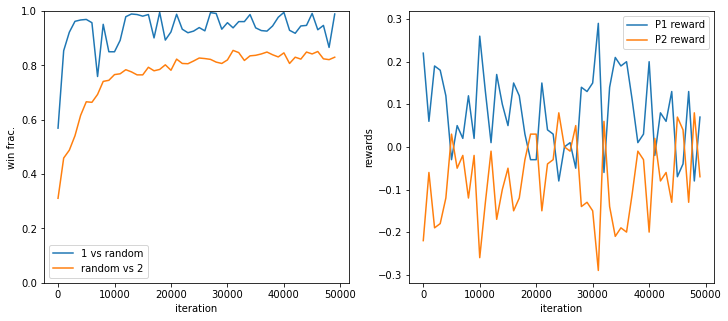

In [4]:
set_seed(9)
q3_player1, q3_player2, stats, rewards = \
    Q_train(n_rows=3, n_cols=3, n_win=3,
            n_iters=50000, n_evals=1000, gamma=1, alpha=0.05, eps=0.2)
plot_results(*stats, None, None, *rewards)

**Интересный факт**: первый игрок не всегда выучивается ставить первым ходом кресик в центре. Если этого не происходит, то он и в этом случае выучивается дальше выводить игру на ничью.

Скорее всего, это связано с тем, что при оптимальной  игре обоих игроков единственный исход - ничья, что и получается при любом обучении. Т.о. **весьма неожиданный минус** подхода одновременного обучения двух игроков - первый игрок выучивается играть именно против идеального соперника, а с неидеальным выводит партию на ничью, не догадываясь, что в принципе мог бы и выиграть. В некотором роде переобучение. Любопытно и наверное жизненно.

#### Первый случайный против второго случайного:

In [5]:
simulate_many(10000, RandomAgent(q3_player1.env, 1), RandomAgent(q3_player1.env, -1))

Counter({1: 5867, -1: 2884, 0: 1249})

#### Первый тренированный против второго тренированного:

In [6]:
simulate_many(10000, q3_player1, q3_player2)

Counter({0: 10000})

#### Первый тренированный против второго случайного:
(есть проигрыши, значит выученная стратегия не идеальна)

In [7]:
simulate_many(10000, q3_player1, RandomAgent(q3_player1.env, -1))

Counter({1: 9908, 0: 92})

#### Первый случайный против второго тренированного:

In [8]:
simulate_many(10000, RandomAgent(q3_player1.env, 1), q3_player2)

Counter({-1: 8155, 1: 484, 0: 1361})

### Поле 4x4x4

Учится довольно долго.

100%|██████████| 3000000/3000000 [1:04:34<00:00, 774.23it/s]


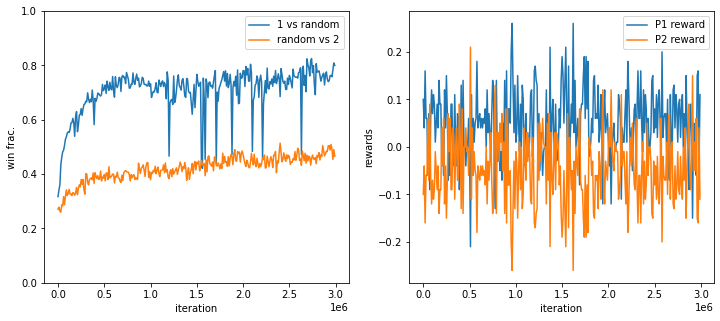

In [9]:
set_seed(9)
q4_player1, q4_player2, stats, rewards = \
    Q_train(n_rows=4, n_cols=4, n_win=4,
            n_iters=3000000, n_check=10000, n_evals=1000, gamma=1, alpha=0.05, eps=0.2)

plot_results(*stats, None, None, *rewards)

#### Первый случайный против второго случайного:

In [10]:
simulate_many(10000, RandomAgent(q4_player1.env, 1), RandomAgent(q4_player1.env, -1))

Counter({0: 4209, 1: 3159, -1: 2632})

#### Первый тренированный против второго тренированного:

In [11]:
simulate_many(10000, q4_player1, q4_player2)

Counter({0: 10000})

#### Первый тренированный против второго случайного:

In [12]:
simulate_many(10000, q4_player1, RandomAgent(q4_player1.env, -1))

Counter({0: 1676, -1: 593, 1: 7731})

#### Первый случайный против второго тренированного:

In [13]:
simulate_many(10000, RandomAgent(q4_player1.env, 1), q4_player2)

Counter({0: 3197, 1: 1991, -1: 4812})

### Поле 5x5x4

Поле 5х5х5 училось бы несколько суток. Взял более быстрый вариант 5x5x4.

100%|██████████| 3000000/3000000 [2:04:55<00:00, 400.25it/s]  


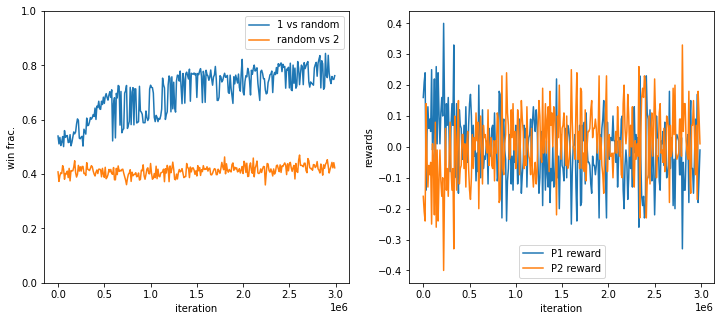

In [14]:
set_seed(9)
q5_player1, q5_player2, stats, rewards = \
    Q_train(n_rows=5, n_cols=5, n_win=4,
            n_iters=3000000, n_check=10000, n_evals=1000, gamma=1, alpha=0.05, eps=0.2)
plot_results(*stats, None, None, *rewards)

#### Первый случайный против второго случайного:

In [15]:
simulate_many(10000, RandomAgent(q5_player1.env, 1), RandomAgent(q5_player1.env, -1))

Counter({1: 5323, -1: 4050, 0: 627})

#### Первый тренированный против второго тренированного:

In [16]:
simulate_many(10000, q5_player1, q5_player2)

Counter({0: 10000})

#### Первый тренированный против второго случайного:

In [17]:
simulate_many(10000, q5_player1, RandomAgent(q5_player1.env, -1))

Counter({1: 7595, -1: 2093, 0: 312})

#### Первый случайный против второго тренированного:

In [18]:
simulate_many(10000, RandomAgent(q5_player1.env, 1), q5_player2)

Counter({-1: 4192, 1: 5145, 0: 663})

## Часть вторая: добавим нейронных сетей

### DQN

Реализовал DQN с target нетворком. 

In [19]:
class DQNModel(nn.Module):
    def __init__(self, field_size, n_linear):
        super().__init__()
        
        if field_size == 3:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=1024, kernel_size=(3, 3)),
                nn.ReLU())
        elif field_size == 4:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=256, kernel_size=(3, 3)),
                nn.ReLU(),
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(2, 2)),
                nn.ReLU())
        elif field_size == 5:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
                nn.ReLU(),
                nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3)),
                nn.ReLU())
        else:
            raise NotImplemented()
        
        self.fc = nn.Sequential(
            nn.Linear(self.conv[-2].out_channels, n_linear),
            nn.ReLU(),
            nn.Linear(n_linear, field_size**2)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return x

In [20]:
FIELD_MARKS = [-1, 0, 1]


class DQNAgent(BaseAgent):
    def __init__(self, env, player, gamma=1.0, eps=0.1, train=True, random=False, n_linear=1024, device='cuda'):
        BaseAgent.__init__(self, env, player, gamma, eps, train)
        self.model = DQNModel(field_size=env.n_rows, n_linear=n_linear).to(device)
        self.target = None
        self.device = device
        self.random = random
        self.memory = ReplayMemory()
        self.counter = 0
            
    def train(self):
        self.is_train = True
        self.model.train()
        
    def eval(self):
        self.is_train = False
        self.model.eval()
        
    def state_as_channels(self, s):
        board = np.array(list(s)).reshape((self.env.n_rows, self.env.n_cols)).astype(int) - 1
        return self.board_as_channels(board)

    def board_as_channels(self, s):
        channels = np.zeros((1, 3, self.env.n_rows, self.env.n_cols))
        for i in range(3):
            channels[0, i] = (s == FIELD_MARKS[i])
        return channels

    @torch.no_grad()
    def get_action(self, s):
        empty_pos = [self.env.int_from_action(a) for a in self.env.getEmptySpaces()]
        if not empty_pos:
            raise Exception('Inconsistency found')
        
        if self.random or (self.is_train and (random.random() < self.eps)):
            a = random.choice(empty_pos)  # int
        else:
            training = self.model.training
            self.model.eval()
            channels = self.board_as_channels(s)
            channels = torch.from_numpy(channels).float().to(self.device)
            output = self.model(channels).cpu().detach().numpy()[0]
            output = output/np.max(output)
            output[empty_pos] += 1e2
            max_actions = np.where(output == output.max())[0]
            a = int(np.random.choice(max_actions))

            self.model.train(training)

        return self.env.action_from_int(a)
    
    def learn(self, s_prev, a_prev, s_cur, a_cur, s_new, r, done):
        reward = self.player * r
        self.memory.store((s_prev, a_prev, s_new, reward, done))

    def update_target(self):
        target = copy.deepcopy(self.model)
        for param in target.parameters():
            target.requires_grad = False
        target.to(self.device)
        self.target = target

In [21]:
def DQN_batch(player, optimizer, criterion, n_batch=128, n_target=100):
    model = player.model
    device = player.device
    player.train()
    env = player.env
    batch = player.memory.sample(n_batch)
    
    states = np.zeros((n_batch, 3, env.n_rows, env.n_cols))
    actions = np.zeros(n_batch)
    new_states = np.zeros((n_batch, 3, env.n_rows, env.n_cols))
    rewards = np.zeros(n_batch)
    dones = np.zeros(n_batch)
    for i, (s, a, s_new, r, done) in enumerate(batch):
        states[i] = player.state_as_channels(s)
        actions[i] = env.int_from_action(a)
        new_states[i] = player.state_as_channels(s_new)
        rewards[i] = r
        dones[i] = done

    states = torch.from_numpy(states).float().to(device)
    actions = torch.from_numpy(actions).long().to(device)
    new_states = torch.from_numpy(new_states).float().to(device)
    rewards = (torch.from_numpy(rewards).float()).to(device)
    dones = (torch.from_numpy(dones).bool()).to(device)

    if player.counter % n_target == 0:
        player.update_target()

    Q = model(states).gather(1, actions.view((-1,1))).reshape(n_batch)
    Q_max = player.target(new_states).max(dim=1)[0]
    Q_max[dones] = 0.0
    Q_max = Q_max.detach()
    Q_next = rewards + player.gamma*Q_max  # target
    loss = criterion(Q, Q_next)
    
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    player.counter += 1
    
    return loss.item(), rewards.detach().mean().item()

In [22]:
def DQN_train(n_rows=3, n_cols=3, n_win=3, 
              n_warmup=1000, n_iters=50000, n_check=1000, n_evals=1000, 
              gamma=1, eps=0.1, lr=3e-4,
              optimizer_cls=torch.optim.Adam, criterion=F.l1_loss, n_batch=128,
              n_linear=1024,
             ):
    ids = []
    res1vsRs = []
    resRvs2s = []
    p1_losses = []
    p2_losses = []
    p1_rewards = []
    p2_rewards = []

    with TicTacToeEnv(n_rows=n_rows, n_cols=n_cols, n_win=n_win) as env:
        player1 = DQNAgent(env,  1, gamma=gamma, eps=eps, n_linear=n_linear)
        player2 = DQNAgent(env, -1, gamma=gamma, eps=eps, n_linear=n_linear)
        optimizer1 = optimizer_cls(player1.model.parameters(), lr=lr, weight_decay=1e-9)
        optimizer2 = optimizer_cls(player2.model.parameters(), lr=lr, weight_decay=1e-9)
        
        for _ in tqdm(range(n_warmup)):
            train_episode(env, player1, player2)

        for i in tqdm(range(n_iters)):
            train_episode(env, player1, player2)

            p1_loss, p1_reward = DQN_batch(player1, optimizer1, criterion, n_batch=n_batch)
            p2_loss, p2_reward = DQN_batch(player2, optimizer2, criterion, n_batch=n_batch)
            p1_losses.append(p1_loss)
            p1_rewards.append(p1_reward)
            p2_losses.append(p2_loss)
            p2_rewards.append(p2_reward)

            if i%n_check == 0:
                ids.append(i)
                res1vsR = simulate_many(n_evals, player1, DQNAgent(env, -1, random=True))[1]/n_evals
                res1vsRs.append(res1vsR)
                resRvs2 = simulate_many(n_evals, DQNAgent(env, 1, random=True), player2)[-1]/n_evals
                resRvs2s.append(resRvs2)

    return player1, player2, (ids, res1vsRs, resRvs2s), (p1_losses, p2_losses), (p1_rewards, p2_rewards)

100%|██████████| 30000/30000 [14:18<00:00, 34.95it/s]


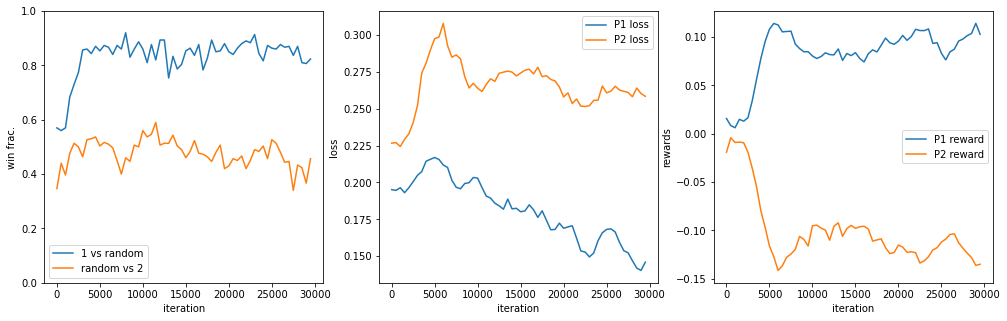

In [23]:
set_seed(9)
player1, player2, stats, losses, rewards = DQN_train(n_rows=3, n_cols=3, n_win=3,
                                            n_warmup=256, n_iters=30000, n_check=500, n_evals=300, n_batch=256,
                                            gamma=0.9, eps=0.4, lr=1e-7,
                                            criterion=F.mse_loss,
                                            n_linear=1024)
dqn_player1 = player1
dqn_player2 = player2

plot_results(*stats, *losses, *rewards)

Результаты немного хуже, чем Q-обучение даже с использованием target сети.

### Double DQN

In [24]:
def DoubleDQN_batch(player, optimizer, criterion, n_batch=128, n_target=100):
    model = player.model
    device = player.device
    player.train()
    env = player.env
    batch = player.memory.sample(n_batch)
    
    states = np.zeros((n_batch, 3, env.n_rows, env.n_cols))
    actions = np.zeros(n_batch)
    new_states = np.zeros((n_batch, 3, env.n_rows, env.n_cols))
    rewards = np.zeros(n_batch)
    dones = np.zeros(n_batch)
    for i, (s, a, s_new, r, done) in enumerate(batch):
        states[i] = player.state_as_channels(s)
        actions[i] = env.int_from_action(a)
        new_states[i] = player.state_as_channels(s_new)
        rewards[i] = r
        dones[i] = done

    states = torch.from_numpy(states).float().to(device)
    actions = torch.from_numpy(actions).long().to(device)
    new_states = torch.from_numpy(new_states).float().to(device)
    rewards = (torch.from_numpy(rewards).float()).to(device)
    dones = (torch.from_numpy(dones).bool()).to(device)
    
    if player.counter % n_target == 0:
        player.update_target()
        
    Q = model(states).gather(1, actions.view((-1,1))).reshape(n_batch)
    a_max = model(new_states).max(dim=1)[1]
    Q_max = player.target(new_states).gather(1, a_max.view((-1,1))).reshape(n_batch)
    Q_max[dones] = 0.0
    Q_max = Q_max.detach()
    Q_next = rewards + player.gamma*Q_max  # target
    loss = criterion(Q, Q_next)
    
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    player.counter += 1
    
    return loss.item(), rewards.detach().mean().item()

In [25]:
def DoubleDQN_train(n_rows=3, n_cols=3, n_win=3, 
                    n_warmup=1000, n_iters=50000, n_check=1000, n_evals=1000, 
                    gamma=1, eps=0.1, lr=3e-4,
                    optimizer_cls=torch.optim.Adam, criterion=F.l1_loss, n_batch=128,
                    n_linear=1024
                   ):
    ids = []
    res1vsRs = []
    resRvs2s = []
    p1_losses = []
    p2_losses = []
    p1_rewards = []
    p2_rewards = []

    with TicTacToeEnv(n_rows=n_rows, n_cols=n_cols, n_win=n_win) as env:
        player1 = DQNAgent(env,  1, gamma=gamma, eps=eps, n_linear=n_linear)
        player2 = DQNAgent(env, -1, gamma=gamma, eps=eps, n_linear=n_linear)   #DQNAgent(env, -1, gamma=gamma, eps=eps)
        optimizer1 = optimizer_cls(player1.model.parameters(), lr=lr, weight_decay=1e-9)
        optimizer2 = optimizer_cls(player2.model.parameters(), lr=lr, weight_decay=1e-9)
        
        for _ in tqdm(range(n_warmup)):
            train_episode(env, player1, player2)

        for i in tqdm(range(n_iters)):
            t = np.clip(i / 10000, 0, 1)
            eps = (1 - t) * 0.7 + t * 0.2
            player1.eps = eps
            player2.eps = eps

            train_episode(env, player1, player2)
            player1.update_target()
            player2.update_target()

            p1_loss, p1_reward = DoubleDQN_batch(player1, optimizer1, criterion, n_batch=n_batch)
            p2_loss, p2_reward = DoubleDQN_batch(player2, optimizer2, criterion, n_batch=n_batch)
            p1_losses.append(p1_loss)
            p1_rewards.append(p1_reward)
            p2_losses.append(p2_loss)
            p2_rewards.append(p2_reward)

            if i%n_check == 0:
                ids.append(i)
                res1vsR = simulate_many(n_evals, player1, DQNAgent(env, -1, random=True))[1]/n_evals
                res1vsRs.append(res1vsR)
                resRvs2 = simulate_many(n_evals, DQNAgent(env, 1, random=True), player2)[-1]/n_evals
                resRvs2s.append(resRvs2)

    return player1, player2, (ids, res1vsRs, resRvs2s), (p1_losses, p2_losses), (p1_rewards, p2_rewards)

100%|██████████| 20000/20000 [10:46<00:00, 30.96it/s]


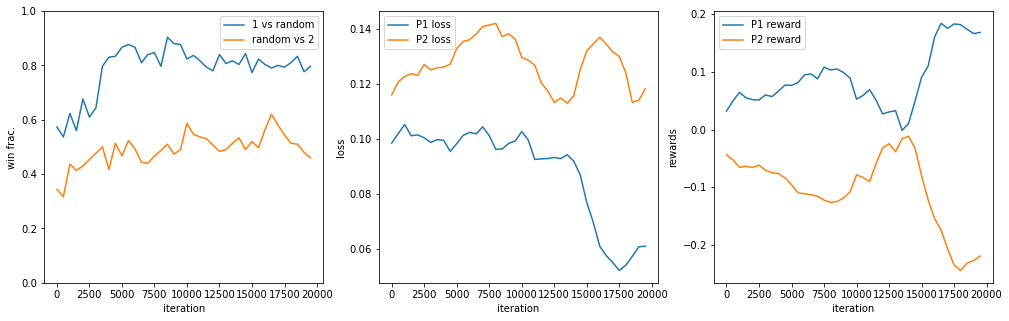

In [26]:
set_seed(9)
player1, player2, stats, losses, rewards = \
    DoubleDQN_train(n_rows=3, n_cols=3, n_win=3,
                    n_warmup=256, n_iters=20000, n_check=500, n_evals=300, n_batch=256,
                    gamma=0.9, eps=0.4, lr=1e-7,
                    criterion=F.smooth_l1_loss,
                    n_linear=1024)
plot_results(*stats, *losses, *rewards)

Лучше по сравнению с обычным DQN не стало. Возможно, дело в переобучении или невером подборе параметров сети. Первый игрок выучивается играть сносно, со вторым хуже.

## Часть третья: расширим и углубим поиск

### Rollouts

In [27]:
class RolloutWrapper(BaseAgent):
    def __init__(self, env, first, second, n_rolls=100):
        BaseAgent.__init__(self, env, player=1)
        self.first = first
        self.second = second
        self.n_rolls = n_rolls

    def get_action(self, s):
        env = self.first.env
        a_avail = env.getEmptySpaces()
        a_max = None
        r_max = -np.inf
        
        for a in a_avail:
            env_a_clone = copy.deepcopy(env)
            self.first.env = env_a_clone
            self.second.env = env_a_clone
            
            (s, _, _), r, done = env_a_clone.step(a)
            if done:
                if r==1:
                    a_max = a
                    r_max = 1
                    break
                else:
                    continue

            rs = []
            for _ in range(self.n_rolls):
                env_clone = copy.deepcopy(env_a_clone)
                self.first.env = env_clone
                self.second.env = env_clone
                _, r = simulate(self.first, self.second, s, first_is_first=False)
                rs.append(r)
            r = np.mean(rs)
            if r > r_max:
                r_max = r
                a_max = a
                
        self.first.env = env
        self.second.env = env

        return a_max or random.choice(a_avail)

    def learn(self, s, a, s_next, r, done):
        pass

#### Первый случайный против второго случайного:

In [28]:
env = TicTacToeEnv(n_rows=3, n_cols=3, n_win=3)
simulate_many(1000, RandomAgent(env, 1), RandomAgent(env, -1), verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 2788.78it/s]


Counter({1: 578, 0: 125, -1: 297})

#### Первый случайный+rollouts против второго случайного:

In [29]:
env = TicTacToeEnv(n_rows=3, n_cols=3, n_win=3)
player1 = RandomAgent(env, 1)    
player2 = RandomAgent(env, -1)
rollout1 = RolloutWrapper(env, player1, player2)
simulate_many(1000, rollout1, player2, verbose=True)

100%|██████████| 1000/1000 [10:08<00:00,  1.64it/s]


Counter({1: 993, 0: 7})

Сработало! Почти 100% побед.

Улучшим результаты 4х4:

#### 4x4 Первый случайный против второго случайного:

In [30]:
env = TicTacToeEnv(n_rows=4, n_cols=4, n_win=4)
simulate_many(1000, RandomAgent(env, 1), RandomAgent(env, -1), verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 1253.72it/s]


Counter({0: 443, -1: 266, 1: 291})

#### 4x4 Первый случайный+rollouts против второго случайного:

In [31]:
env = TicTacToeEnv(n_rows=4, n_cols=4, n_win=4)
player1 = RandomAgent(env, 1)    
player2 = RandomAgent(env, -1)
rollout1 = RolloutWrapper(env, player1, player2)
simulate_many(1000, rollout1, player2, verbose=True)

100%|██████████| 1000/1000 [58:07<00:00,  3.49s/it]


Counter({1: 978, 0: 22})

Получилось.

Усложним задачу: **4x4 Первый случайный+rollouts против второго обученного.**

In [32]:
env = TicTacToeEnv(n_rows=4, n_cols=4, n_win=4)
player1 = RandomAgent(env, 1)
rollout1 = RolloutWrapper(env, player1, player2) 
q4_player2.env = env
simulate_many(1000, rollout1, q4_player2, verbose=True)

100%|██████████| 1000/1000 [1:01:16<00:00,  3.68s/it]


Counter({0: 181, 1: 817, -1: 2})

Немного хуже, что и понятно - стратегия второго была не случайная. Выглядит правдоподобно.  

### MCTS

In [33]:
class Node:
    def __init__(self, player, n_actions, state, reward=None):
        self.state = state
        self.player = player
        self.parent = None
        self.children = [None]*n_actions
        self.reward = reward   # reward is not None == node is leaf (reward is unscaled 1-for tics and -1 for tacs)
        self.wins   = 0
        self.losses = 0
        self.total  = 0

    def add_child(self, state, action, reward):
        child = Node(-self.player, len(self.children), state, reward)
        child.parent = self
        self.children[action] = child
        return child

    def backprop(self, counter):  # wins, losses according to Player 1 !
        wins = counter[1]
        losses = counter[-1]
        total = sum(counter.values())
        
        self.wins   += (wins if self.player==-1 else losses)
        self.losses += (losses if self.player==-1 else wins)
        self.total  += total

        if self.parent:
            self.parent.backprop(counter)
            
    def win_frac(self):
        return self.wins/self.total
    
    def depth(self):
        return 0 if self.parent is None else 1 + self.parent.depth()
    
    def __repr__(self):
        space = ' '*3*(self.depth() + 1)
        space = f"\n{space}"
        children = ''
        for i, child in enumerate(self.children):
            if child:
                children += space + str(i + 1) + ' ' + str(child)
        return f'node[{self.player}] ' + \
               f'({self.wins}/{self.losses}/{self.total} {round(self.wins/self.total, 2)}:{round(self.losses/self.total, 2)}), ' + \
               f's={self.state} r={self.reward}:{children}'

In [34]:
class MCTSWrapper(BaseAgent):
    def __init__(self, env, first, second):
        BaseAgent.__init__(self, env, player=1)
        self.first = first
        self.second = second
        self.tree = Node(player=1, n_actions=env.n_rows*env.n_cols, state=env.get_state()[0])
        
    def set_env(self, env):
        self.env = env
        self.first.env = env
        self.second.env = env

    @staticmethod
    def get_UCT(parent, child, C):
        return -1 if child is None else child.win_frac() + C*np.sqrt(np.log(parent.total) / child.total)
    
    def train_episode(self, n_rolls=100, c_explore=1.0):
        self.env.reset()
        node = self.tree

        while True:
            avail_actions = [self.env.int_from_action(a) for a in self.env.getEmptySpaces()]
            new_actions = [i for i, e in enumerate(node.children) if e is None]
            new_actions = list(set(avail_actions) & set(new_actions))

            env_a_clone = copy.deepcopy(self.env)
            
            if new_actions:
                # if any new actions - select from it
                a = random.choice(new_actions)
                (s, _, _), r, done = self.env.step(self.env.action_from_int(a))
                r = r if done else None
                child = node.add_child(s, a, r)
                
                # rollout
                if not done:
                    rs = []
                    for _ in range(n_rolls):
                        env_clone = copy.deepcopy(self.env)
                        self.first.env = env_clone
                        self.second.env = env_clone
                        _, r = simulate(self.first, self.second, child.state, first_is_first=False)
                        rs.append(r)
                    rs = Counter(rs)
                else:
                    rs = Counter([child.reward])
                    
                child.backprop(rs)
                
                self.set_env(env_a_clone)
            else:
                # if all children are opened - select from them by UCT
                ucts = [self.get_UCT(node, child, c_explore) for child in node.children]
                a = np.argmax(ucts)
                child = node.children[a]
                
                a = self.env.action_from_int(a)
                (s, _, _), r, done = self.first.env.step(a)
                r = r if done else None
                assert child.state == s
                assert child.reward == r
                if done:
                    child.backprop(Counter([child.reward]))
                    break
                
                s, a, r, done = self.second.step_from(s)
                a = self.env.int_from_action(a)
                r = r if done else None
                if not child.children[a]:
                    child.add_child(s, a, r)
                node = child.children[a]
                if done:
                    node.backprop(Counter([child.reward]))
                    break


set_seed(9)
env = TicTacToeEnv(n_rows=3, n_cols=3, n_win=3)
player1 = RandomAgent(env, 1)
player2 = RandomAgent(env, -1)
mcts_player1 = MCTSWrapper(env, first=player1, second=player2)
mcts_player1.train_episode(n_rolls=1000, c_explore=1.0)

mcts_player1.tree.wins, mcts_player1.tree.losses, mcts_player1.tree.total

(4885, 13205, 20002)

In [35]:
mcts_player1.tree

node[1] (4885/13205/20002 0.24:0.66), s=111111111 r=None:
   1 node[-1] (623/261/1000 0.62:0.26), s=211111111 r=None:
   2 node[-1] (539/333/1000 0.54:0.33), s=121111111 r=None:
   3 node[-1] (609/270/1000 0.61:0.27), s=112111111 r=None:
   4 node[-1] (546/334/1000 0.55:0.33), s=111211111 r=None:
   5 node[-1] (8584/2463/12002 0.72:0.21), s=111121111 r=None:
      1 node[1] (2279/7880/11002 0.21:0.72), s=011121111 r=None:
         2 node[-1] (668/168/1000 0.67:0.17), s=021121111 r=None:
         3 node[-1] (4042/866/5002 0.81:0.17), s=012121111 r=None:
            9 node[1] (678/3324/4002 0.17:0.83), s=012121110 r=None:
               2 node[-1] (764/236/1000 0.76:0.24), s=022121110 r=None:
               4 node[-1] (911/89/1000 0.91:0.09), s=012221110 r=None:
               6 node[-1] (729/271/1000 0.73:0.27), s=012122110 r=None:
               7 node[-1] (2/0/2 1.0:0.0), s=012121210 r=1:
               8 node[-1] (918/82/1000 0.92:0.08), s=012121120 r=None:
         4 node[-1] (690/1

In [39]:
def MCTS_simulate(wrapper):
    states = []
    env = wrapper.env
    s, _, _ = env.reset()
    
    node = wrapper.tree
    child = None
    player1, player2 = wrapper.first, wrapper.second
    player1.env = env
    player2.env = env
    
    p1_train = player1.is_train
    p2_train = player2.is_train
    player1.eval()
    player2.eval()
    
    while True:
        if node:
            if node.reward:
                r = node.reward
                break
            
            children = list(filter(None, node.children)) if node else None
            assert children
            
            a = np.argmax([(c.win_frac() if c else -1) for c in node.children])
            child = node.children[a]
            a = env.action_from_int(a)
            (s, _, _), r, done = env.step(a)
            if done:
                break

            r = r if done else None
            states.append(s)
            assert child.state == s
            assert child.reward == r
            if child.reward:
                r = child.reward
                break
        else:
            s, a, r, done = player1.step_from(s)
            r = r if done else None
            states.append(s)
            if done:
                break
                
        s, a, r, done = player2.step_from(s)
        a = env.int_from_action(a)
        r = r if done else None
        states.append(s)
        if done:
            break
            
        if child and child.children[a]:
            node = child.children[a]
            assert node.state == s
            assert node.reward == r
        else:
            node = None
            child = None

    return r


def MCTS_simulate_many(n_sims, wrapper, verbose=False):
    rs = []
    for _ in tqdm(range(n_sims), disable=not verbose):
        r = MCTS_simulate(wrapper)
        rs.append(r)

    return Counter(rs)

In [40]:
def MCTS_train(env, player1, player2,
               n_iters=20000, n_check=1000, n_evals=1000, c_explore=1.5, n_rolls=100):
    ids = []
    res1vsRs = []
    resRvs2s = []
    p1_rewards = []
    p2_rewards = []

    mcts_player1 = MCTSWrapper(env, first=player1, second=player2)

    for i in tqdm(range(n_iters)):
        mcts_player1.train_episode(n_rolls, c_explore)
        r = (mcts_player1.tree.wins - mcts_player1.tree.losses) / mcts_player1.tree.total
        p1_rewards.append(r)
        p2_rewards.append(-r)

        if i%n_check == 0:
            ids.append(i)
            sim_res = MCTS_simulate_many(n_evals, mcts_player1)
            res1vsRs.append(sim_res[1]/n_evals)
            resRvs2s.append(sim_res[-1]/n_evals)

    return mcts_player1, (ids, res1vsRs, resRvs2s), (p1_rewards, p2_rewards)

#### Поле: 3x3 

100%|██████████| 3000/3000 [15:20<00:00,  3.26it/s]


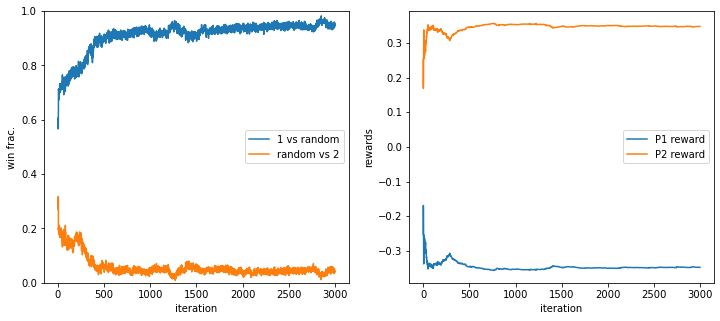

In [41]:
set_seed(9)

with TicTacToeEnv(n_rows=3, n_cols=3, n_win=3) as env:
    player1 = RandomAgent(env, 1)
    player2 = RandomAgent(env, -1)
    mcts_player1, stats, rewards = \
        MCTS_train(env, player1, player2,
                   n_iters=3000, n_check=1, n_evals=1000, c_explore=1.5, n_rolls=10)

plot_results(*stats, None, None, *rewards, window=1)

#### Поле 4x4:

100%|██████████| 50000/50000 [2:13:16<00:00,  6.25it/s]  


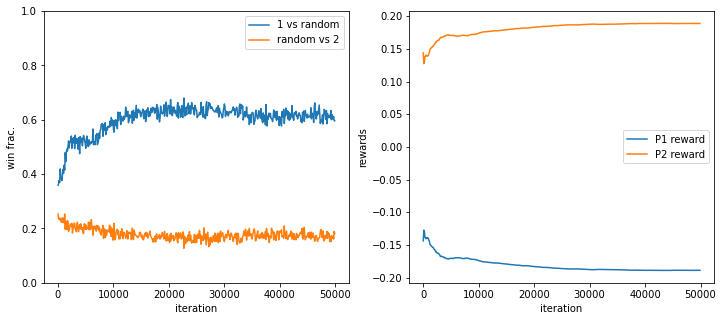

In [42]:
set_seed(9)

with TicTacToeEnv(n_rows=4, n_cols=4, n_win=4) as env:
    player1 = RandomAgent(env, 1)
    player2 = RandomAgent(env, -1)
    mcts_player1, stats, rewards = \
        MCTS_train(env, player1, player2,
                   n_iters=50000, n_check=100, n_evals=1000, c_explore=1.5, n_rolls=30)

plot_results(*stats, None, None, *rewards, window=10)

Вывод: MCTS, тренированный даже на рандоме, выстреливает достаточно хорошо. Но для тренировки, скажем, 5х5 поля требуются миллионы итераций с достаточно большим числом роллаутов. На 50к итерацийполучилось удвоить шансы победы.

## Planning

Вместо бонуса :)

На AlphaZero времени не осталось, но попробовать обучать модель все-таки было интересно попробовать.

Модель сделаем как простой Cоunter состояний, но брать следующее состояние из модели будем именно согласно этим частотам, что будет чем-то похоже на prioritized sweeping.

### Dyna

In [43]:
class FreqModel:
    def __init__(self, capacity=100):
        self.capacity = capacity
        self.memory = defaultdict(list)
        self.positions = defaultdict(int)
        
    def add(self, s, a, s_, r):
        chain = self.memory[(s, a)]
        if len(chain) < self.capacity:
            chain.append(None)
        position = self.positions[(s, a)]
        chain[position] = (s_, r)
        self.positions[(s, a)] = (position + 1) % self.capacity

    def sample(self, s, a):
        chain = self.memory[(s, a)]
        total = len(chain)
        if total == 0:
            return None, None
        
        roll = random.randint(0, total - 1)
        return chain[roll]

In [44]:
class DynaQAgent(QAgent):
    def __init__(self, env, player, alpha=0.1, gamma=1.0, eps=0.1, k_model=10, train=True, random=False):
        QAgent.__init__(self, env, player, alpha, gamma, eps, train, random)
        self.k_model = k_model
        self.M = FreqModel()

    def memory(self, s, a, s_, r):
        self.M.add(s, a, s_, r)
    
    def simulate(self):
        for _ in range(self.k_model):
            s, a = random.choice(list(self.M.memory.keys()))
            s_, r = self.M.sample(s, a)
            self.update_Q(s, a, s_, r)
        
    def learn(self, s_prev, a_prev, s_cur, a_cur, s_new, r, done):
        self.update_Q(s_prev, a_prev, s_new, r)
        self.memory(s_prev, a_prev, s_new, r)
        self.simulate()   

In [45]:
def DynaQ_train(n_rows=3, n_cols=3, n_win=3, k_model=10, 
                n_iters=50000, n_check=1000, n_evals=1000, gamma=1, alpha=0.1, eps=0.1):
    ids = []
    res1vsRs = []
    resRvs2s = []
    p1_rewards = []
    p2_rewards = []

    with TicTacToeEnv(n_rows=n_rows, n_cols=n_cols, n_win=n_win) as env:
        player1 = DynaQAgent(env,  1, gamma=gamma, alpha=alpha, eps=eps, k_model=k_model)
        player2 = DynaQAgent(env, -1, gamma=gamma, alpha=alpha, eps=eps, k_model=k_model)

        for i in tqdm(range(n_iters)):
            r = train_episode(env, player1, player2)
            p1_rewards.append(r)
            p2_rewards.append(-r)

            if i%n_check == 0:
                ids.append(i)
                res1vsR = simulate_many(n_evals, player1, QAgent(player1.env, -1, random=True))[1]/n_evals
                res1vsRs.append(res1vsR)
                resRvs2 = simulate_many(n_evals, QAgent(player1.env, 1, random=True), player2)[-1]/n_evals
                resRvs2s.append(resRvs2)

    return player1, player2, (ids, res1vsRs, resRvs2s), (p1_rewards, p2_rewards)

####  Поле 3x3x3

100%|██████████| 50000/50000 [04:58<00:00, 167.25it/s]


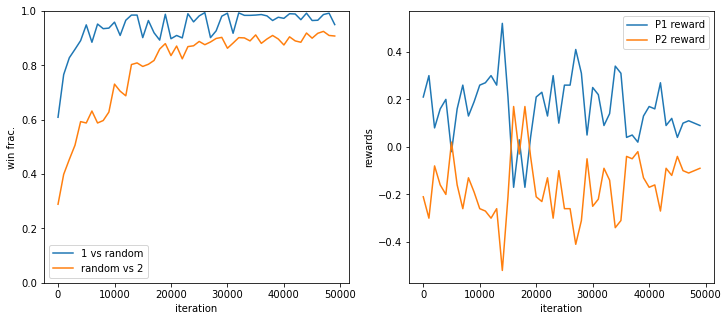

In [46]:
set_seed(9)
player1, player2, stats, rewards = \
    DynaQ_train(n_rows=3, n_cols=3, n_win=3,
            k_model=10, n_iters=50000, n_evals=1000, gamma=1, alpha=0.05, eps=0.2)
plot_results(*stats, None, None, *rewards)

Учится дольше, но второй игрок стал играть лучше, а первый стабильнее!

## Выводы

- еще раз попрактиковались в Q-лернинге. Полезен в т.ч. как базовая стратегия в продвинутых decision-time planning методах.
- нейронные сетиотработали странно, не получилось доучить до винрейта = 1 у первого игрока (максимум 0.92). Возможно, где-то баг.
- decision-time planning методы отлично работают. Даже простые роллауты работают неплохо, не говоря уже об MCTS.
- выучивание модели вместе со стратегией (e.g. Dyna) тоже хорошо заходит.

<div style='visibility:hidden'>
11111111111111111111111111111111111111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111122222222222222222222222222222233333333333333333333333333333333333333333333333333333333333333334444444444444444444444444444444444444444444444444444444444444455555555555555556666666666666666666666666666666666666666666666666666666666666666666666666677777777777777777778888888888888888889999999999999999999999999999999999999999999999999999999999999999999999999999999999999999997777777777777777777777777777777777777777773333333333333333333333333333333355555555555555555555551111111111111111111111111113333333333333333333322222222222222226666666666666666666666666666666666666666665555555555555555555554326666666777789553425354545454355555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555553333333333333333333333337777777777777777777777777777777777777777777777777777777777777777777777777777777999999999999999988888888888888777777775555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555554321111111111111111111116666666666666666666666666666666666666666666666666666666666666666666666666666666666600988766544444432221111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------========================================================================================================================================================================================================================000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111122222222222222222222222222222222222222222222222222222222222222222222222333333333333333333333333333333333333333333333333333333333333333333333334444444444444444444444444444444444444444444444444444444444444444444444444444444444444555555555555555555555555555555555555555555555555555555555555555555555555556666666666666666666666666666666666666666666666666666666666666666666666677777777777777777777777777777777777777777777777777777777777777777777777788888888888888888888888888888888888888888888888888888888888888888888888999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999910101010101010101010101010101010101010101010101010101010101010101010101111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000030313233343536373839404142434445464748495051525354555657585960
</div>